说到 Embedding，就不得不提到 BERT 模型，这是一个使用 Transformer Encoder 的强大嵌入工具。

嵌入模型的作用，是将人类语言转换成机器可以理解和快速准确地比较的格式。这类模型可以将文本作为输入并生成固定长度的数字数组，即文本语义的数字指纹。嵌入允许搜索系统不仅基于关键字匹配，还基于语义理解来查找相关文档，从而成为了 RAG 系统的最重要基础。

![Text Embedding and Similarity](https://python.langchain.com/assets/images/embeddings_concept-975a9aaba52de05b457a1aeff9a7393a.png)

同时，由于 Embedding 操作离不开文件系统，这是 LangChain 的 [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html#document) 类的官方文档。所有 LangChain 官方提供的可 Embedding models 在[这里](https://python.langchain.com/docs/integrations/text_embedding/)列举出来。

In [1]:
from dotenv import load_dotenv, find_dotenv
from numpy import ndarray

_ = load_dotenv(find_dotenv())

from langchain_openai import ChatOpenAI

# 我们仍旧使用 GPT-4o，这是一个支持多模态的 LLM
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,  # 让我们的 LLM 最准确
    max_tokens=2048,
    timeout=None,
    max_retries=2,
)

我们使用 OpenAI 的 text embedding，`OpenAIEmbeddings` 类的官方文档在[这里](https://python.langchain.com/api_reference/openai/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html)，里面包含了许多可以定制化的属性。

* `.embed_documents()` 用于嵌入 `List` 类型的文本；
* `.embed_query` 用于嵌入单个 `str` 类型的文本。

In [24]:
from langchain_openai import OpenAIEmbeddings

embeddings_llm = OpenAIEmbeddings(model="text-embedding-3-large")

# 我们简单使用 5 句话进行句子嵌入
sentences = [
    "Hello, world!",
    "I am a student.",
    "你好世界。",
    "Meaning of life is 42.",
    "Je suis étudiant."
]
embeddings = embeddings_llm.embed_documents(sentences)

In [25]:
# 嵌入的维度大小一直都在随着版本进行变化
print("Length of Embeddings: ({}, {})".format(len(embeddings), len(embeddings[0])))
print(type(embeddings[0]))

Length of Embeddings: (5, 3072)
<class 'list'>


来一段机器学习上的概念：
> 嵌入本质上都是一组坐标，通常位于高维空间中。在这个空间中，每个点（嵌入）的位置反映了其对应文本的含义。就像同义词库中的相似单词可能彼此靠近一样，相似的概念最终也会在这个嵌入空间中彼此靠近。这允许直观地比较不同的文本。
>
> 通过将文本简化为这些数字表示，我们可以使用简单的数学运算来快速测量两段文本的相似程度，无论它们的原始长度或结构如何。

相似性指标包括：
* 余弦相似度：向量之间的角度的余弦（高度相似为1，完全不相似为0）
* 欧几里得距离（Euclidean Dist）：距离越近越相似
* 点积：投影越大越相似

OpenAI 在官方文档中建议我们使用[余弦相似度](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use#which-distance-function-should-i-use)。

线性代数里面余弦相似度的公式为：

$$
cos(\theta) = \frac{v_1 \cdot v_2}{||v_1|| \cdot ||v_2||}
$$

In [26]:
import numpy as np

embeddings = np.array(embeddings)

# 我们根据官方教程手写一个 cosine 相似度函数
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

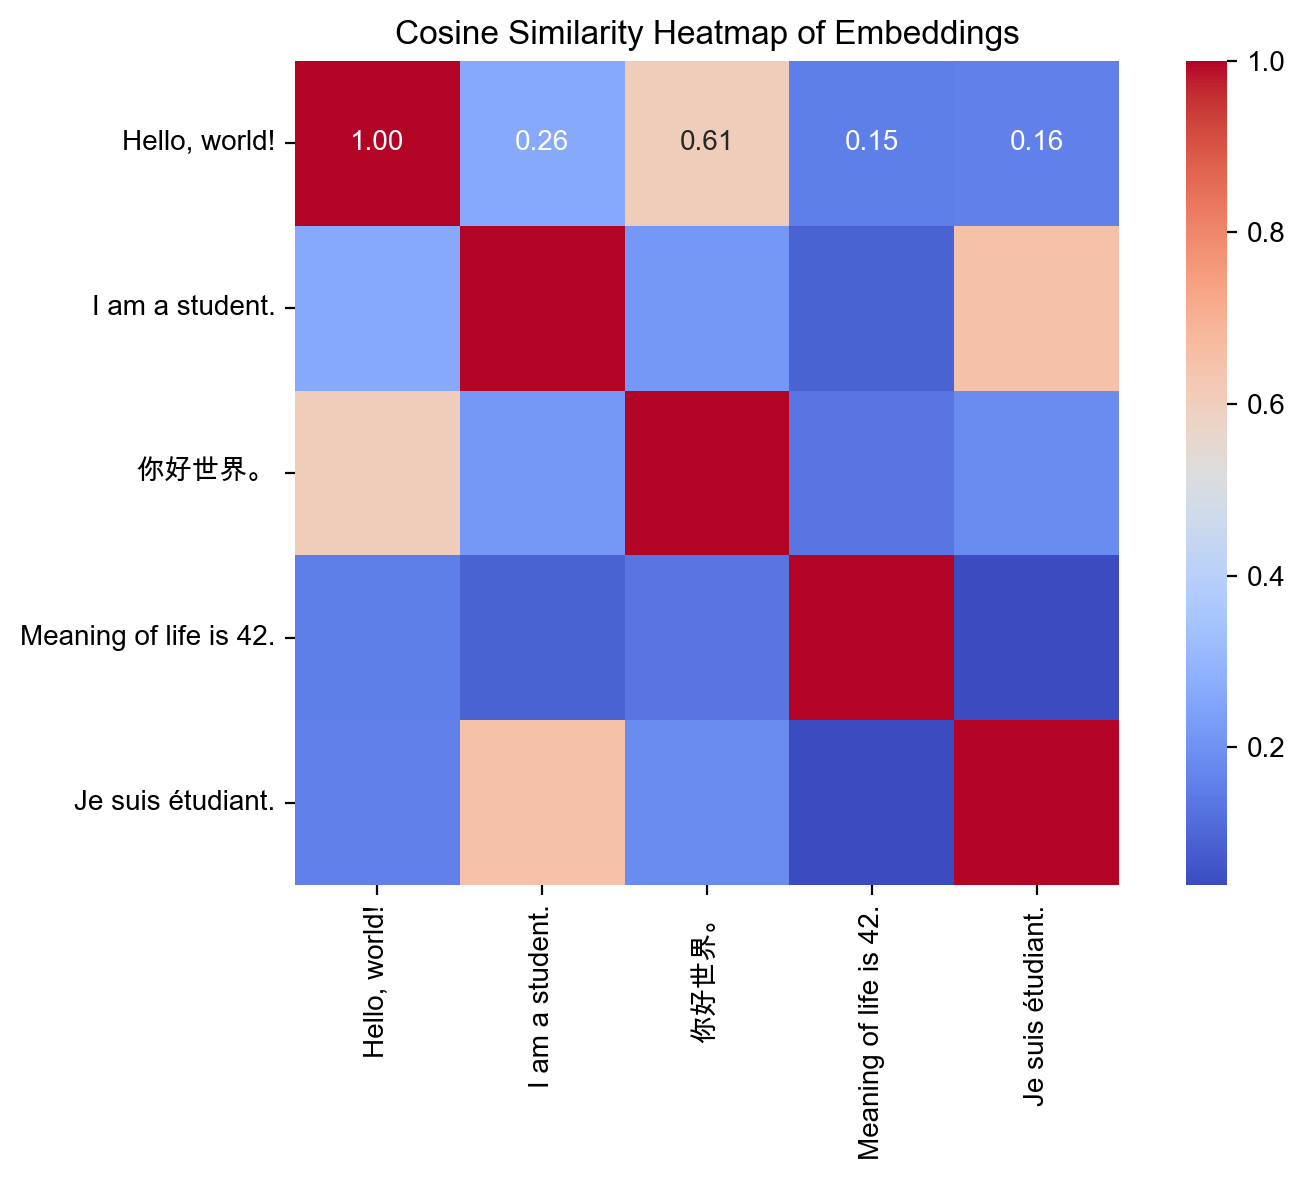

In [27]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

n = len(embeddings)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i][j] = cosine_similarity(embeddings[i], embeddings[j])

# 转换为 DataFrame 方便 seaborn 可视化
df_sim = pd.DataFrame(similarity_matrix, index=sentences, columns=sentences)

# 绘制热力图
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(df_sim, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Cosine Similarity Heatmap of Embeddings")
plt.tight_layout()
plt.show()

可以看到，经过词嵌入之后，英文的 “Hello, world” 和中文的 “你好世界” 的嵌入相似度很高，英文的 “I am a student” 和法语的 “Je suis étudiant” 非常接近。尽管语言不通，但是它们相似度更高，说明它们两者之间有这明确的关系，这也是深度学习解决机器翻译问题的基础。